In [2]:
import pandas as pd
import pickle
from tqdm import tqdm_notebook as tqdm
import numpy as np
from wac import WAC

from keras.preprocessing import image
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.models import Model, load_model
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input

Using TensorFlow backend.


In [4]:
data = pd.read_pickle('../data/sentiment_data.pickle')
data['file_name'] = data.file_name.apply(lambda x: x.replace(' ', '_').split('.')[0])

emotions = ['interest','alarm','confusion','understanding','frustration','relief','sorrow','joy','anger','gratitude','fear','hope','boredom','surprise','disgust','desire']

In [5]:
data[:3]

file_name   embed_code  video_title  \
20                 anim_play_requestplay_level2_01  nMbYAONAots           21   
21                               anim_play_idle_02  DDU9jeo3Y8c           22   
22  anim_reacttoface_unidentified_03_head_angle_40  D0MyBZXzlFg           23   

                                          description  interest  alarm  \
20  The robot comes closer to the camera, showing ...         0      0   
21  The robot stays pretty still and then seems to...         0      0   
22  The robot stares right at the camera and then ...         1      0   

    confusion  understanding  frustration  relief  sorrow  joy  anger  \
20          0              0            0       0       0    0      0   
21          0              0            0       0       0    0      0   
22          0              0            0       0       0    0      0   

    gratitude  fear  hope  boredom  surprise  disgust  desire  
20          0     0     0        0         0        0       1  
21          0     0     0        1         0        0       0  
22          0     0     0        0         0        0       0

In [6]:
data.shape

(940, 20)

In [7]:
emotions_ind = {i:e for i,e in enumerate(emotions)}

emotions_ind

{0: 'interest',
 1: 'alarm',
 2: 'confusion',
 3: 'understanding',
 4: 'frustration',
 5: 'relief',
 6: 'sorrow',
 7: 'joy',
 8: 'anger',
 9: 'gratitude',
 10: 'fear',
 11: 'hope',
 12: 'boredom',
 13: 'surprise',
 14: 'disgust',
 15: 'desire'}

#### How many anims for each emotion?

In [8]:
max_frames = []
for e in emotions:
    l = len(data[data[e] == 1])
    max_frames.append(l)
    print(e, l)
    
max_frames = max(max_frames)

max_frames

interest 208
alarm 97
confusion 142
understanding 113
frustration 104
relief 75
sorrow 139
joy 136
anger 95
gratitude 79
fear 114
hope 81
boredom 81
surprise 124
disgust 53
desire 63


208

In [9]:
import os
import ast

In [10]:
dev = pd.read_pickle('../data/dev.pkl')
train = pd.read_pickle('../data/train.pkl')

for e in emotions:
    print(e,len(train[train[e] == 1]),len(dev[dev[e] == 1]))
    
len(train)

interest 119 71
alarm 43 52
confusion 110 43
understanding 53 35
frustration 77 35
relief 28 26
sorrow 112 27
joy 66 50
anger 55 37
gratitude 25 23
fear 59 44
hope 21 27
boredom 124 15
surprise 64 68
disgust 22 17
desire 30 19


1008

In [11]:
START_COL = 'interest'
END_COL = 'desire'


def get_y(d):
    return d.loc[:,START_COL:END_COL].as_matrix()

def get_X(d):
    X = []
    for a in d.file_name:
        with open('data/padded_vgg19/{}.pkl'.format(a), 'rb') as f:
            inc = pickle.load(f)
            X.append(inc)
    
    return np.array(X)

In [12]:
y = get_y(train)
X = get_X(train)
print(len(X))

max_sequence = max([len(s) for s in X])

#X = pad_sequences(X, maxlen=max_sequence, padding='post')
#print(X.shape)
#X = X.reshape((X.shape[0],X.shape[1],1))

test = dev

y_test = get_y(test)
X_test = get_X(test)

#X_test = pad_sequences(X_test, maxlen=max_sequence, padding='post')

#X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

y[0],  max_sequence

/Users/DavidMcNeill1/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


FileNotFoundError: [Errno 2] No such file or directory: 'data/padded_vgg19/anim_pyramid_lookinplaceforfaces_short_head_angle_40.pkl'

In [53]:
import random
#random.seed(a=200)
from sklearn import tree
from sklearn import neural_network
from sklearn import linear_model
from sklearn import gaussian_process
from sklearn import naive_bayes
from sklearn import ensemble
from wac import WAC

mlp_spec = (neural_network.MLPClassifier, {'hidden_layer_sizes':(128,64,32), 'solver':'adam', 'max_iter':1000, 'alpha':1e-05})
tree_spec = (tree.DecisionTreeClassifier,{'criterion':'gini'})
lr_spec=(linear_model.LogisticRegression,{'penalty':'l1'})
rf_spec = (ensemble.RandomForestClassifier, {'n_estimators':10, 'max_depth':2})
gauss_spec = (gaussian_process.GaussianProcessClassifier, {})
nb_spec= (naive_bayes.GaussianNB, {})

In [54]:
wac = WAC('cozmo', mlp_spec)
    
X_y = list(zip(X,y))

for x,y_t in X_y:
    ind = np.argmax(y_t, axis=0)
    ind = emotions_ind[ind]
    for x_t in x:
        wac.add_observation(ind, x_t, [1])
        for i in range(5) : # add negative observations
            neg_X,neg_y = random.choice(X_y)
            neg_X = random.choice(neg_X)
            neg_y = np.argmax(neg_y, axis=0)
            neg_ind  = emotions_ind[neg_y]
            while neg_ind == ind:
                neg_X,neg_y = random.choice(X_y)
                neg_X = random.choice(neg_X)
                neg_y = np.argmax(neg_y, axis=0)
                neg_ind  = emotions_ind[neg_y]
            wac.add_observation(ind, neg_X, [0])    


In [55]:
wac.train()

desire 14946


/home/casey/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:912: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


boredom 42780
interest 207162
sorrow 79434
alarm 55014
anger 45972
frustration 58692
fear 34380
surprise 29322
confusion 105684
disgust 9636
joy 59310
understanding 31206
relief 23088
hope 14250
gratitude 15960


In [56]:
len(wac.wac.keys()), len(emotions) # the two numbers should be the same

(16, 16)

In [57]:
from operator import itemgetter

guesses= []
golds = []

X_y_test = list(zip(X_test, y_test))

for x,y_t in X_y_test:
    wac.new_utt()
    for x_t in x:
        context = (['i'],[x_t])
        predictions = [(e,wac.proba(e,context)[0][1]) for e in emotions]
        wac.compose(predictions)
        #guess = max(predictions,key=itemgetter(1))[0]
    guess = wac.get_predicted_intent()
    guesses.append(guess[0])
    golds.append(emotions_ind[np.argmax(y_t, axis=0)])

#list(zip(guesses, golds))

In [58]:
from sklearn.metrics import accuracy_score

print(accuracy_score(guesses, golds))

0.04

In [59]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.figure(figsize=(20,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    

Confusion matrix, without normalization
[[0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0]
 [0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0]
 [1 0 0 3 0 0 0 1 0 0 2 0 0 0 0 0]
 [0 1 0 1 0 0 1 0 1 0 1 4 1 1 0 1]
 [0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 2 0 0 0 0 0 0 1 0 0 0 0 0]
 [0 1 0 2 0 0 0 0 0 1 1 0 0 1 1 2]
 [0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 1]
 [0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0]
 [3 1 0 1 0 0 2 0 2 2 5 2 1 1 2 2]
 [0 0 0 1 0 0 0 0 0 1 4 0 0 0 1 0]
 [0 1 0 2 0 0 0 0 0 0 3 1 0 0 0 0]
 [0 1 0 1 1 0 0 0 0 0 2 1 0 2 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0]
 [2 0 0 1 1 0 0 0 0 2 2 0 0 0 0 0]]


<Figure size 432x288 with 0 Axes>

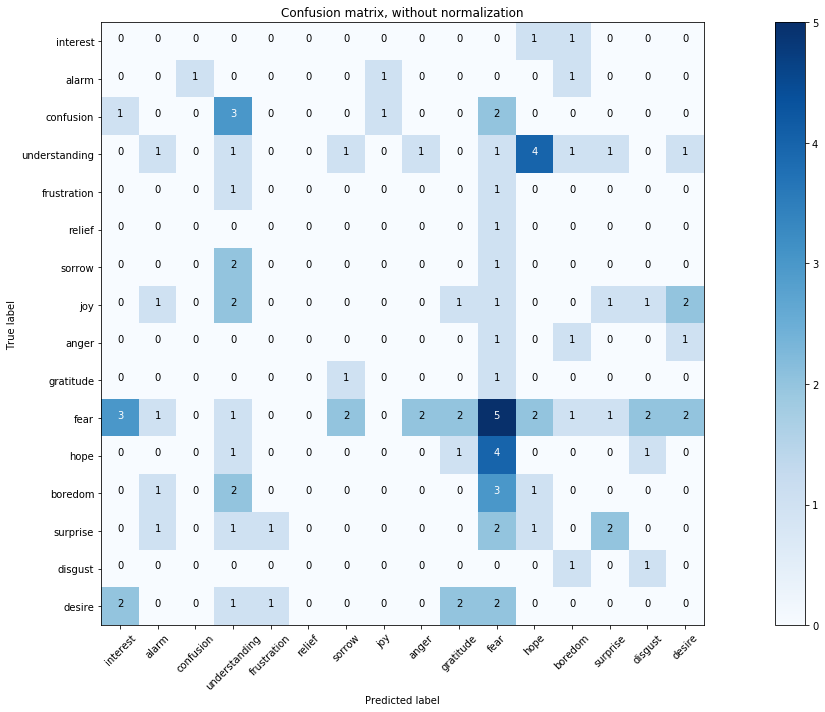

In [32]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(golds, guesses)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=emotions,
                      title='Confusion matrix, without normalization')